In [ ]:
!pip install tensorflow
!pip install tensorflow.keras
!pip install keras

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import seaborn as sns
from pathlib import Path
import imghdr
import random

<ipython-input-4-08404aed3447>:16: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
VALIDATION_SPLIT = 0.2

# Define the plastic types/classes
CLASSES = ['PET', 'HDPE', 'PVC', 'LDPE', 'PP', 'PS']

dataset_path="/content/Dataset"


In [ ]:
# Step 1: Data Exploration and Setup

def clean_dataset(dataset_path):
    """
    Clean the dataset by removing non-image files and validating images.

    Args:
        dataset_path: Path to the dataset root directory

    Returns:
        A list of valid image paths and their corresponding labels
    """
    valid_images = []
    labels = []
    non_image_files = []
    non_image_extensions = set()

    for class_name in CLASSES:
        class_dir = os.path.join(dataset_path, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory {class_dir} does not exist.")
            continue

        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)

            # Skip directories
            if os.path.isdir(file_path):
                continue

            # Check if file is a valid image
            try:
                img = Image.open(file_path)
                img.verify()  # Verify it's a valid image
                valid_images.append(file_path)
                labels.append(class_name)
            except (IOError, SyntaxError) as e:
                non_image_files.append(file_path)
                extension = os.path.splitext(file_name)[1].lower()
                non_image_extensions.add(extension)

    print(f"Number of valid image files: {len(valid_images)}")
    print(f"Number of non-image files: {len(non_image_files)}")
    print(f"Non-image file extensions: {non_image_extensions}")

    return valid_images, labels

def explore_dataset(image_paths, labels):
    """
    Explore the dataset and show statistics and sample images.

    Args:
        image_paths: List of paths to valid images
        labels: List of corresponding labels
    """
    # Check class distribution
    class_counts = {}
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

    # Display class distribution
    print("Class distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images ({count/len(labels)*100:.2f}%)")

    # Plot class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xlabel('Plastic Type')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Display sample images from each class
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(CLASSES):
        class_images = [img for img, lbl in zip(image_paths, labels) if lbl == class_name]
        if class_images:
            # Get up to 5 random samples
            samples = min(5, len(class_images))
            for j in range(samples):
                if j < len(class_images):
                    plt.subplot(len(CLASSES), 5, i*5 + j + 1)
                    sample_img = Image.open(class_images[j])
                    plt.imshow(sample_img)
                    plt.title(f"{class_name} - {j+1}")
                    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Check image sizes
    sizes = []
    for img_path in random.sample(image_paths, min(100, len(image_paths))):
        img = Image.open(img_path)
        sizes.append(img.size)

    print("Sample of image dimensions:")
    unique_sizes = set(sizes)
    for size in unique_sizes:
        count = sizes.count(size)
        print(f"Size {size}: {count} images")

In [ ]:
# Step 2: Dataset Preprocessing

def create_datasets(image_paths, labels, validation_split=0.2):
    """
    Create training and validation datasets.

    Args:
        image_paths: List of paths to valid images
        labels: List of corresponding labels
        validation_split: Proportion of data to use for validation

    Returns:
        Train dataset and validation dataset
    """
    # Convert class names to indices
    class_to_idx = {class_name: i for i, class_name in enumerate(CLASSES)}
    label_indices = [class_to_idx[label] for label in labels]

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels,
        'label_idx': label_indices
    })

    # Split into training and validation sets
    train_df, val_df = train_test_split(
        df, test_size=validation_split,
        stratify=df['label_idx'],  # Ensure balanced classes
        random_state=42
    )

    print(f"Training set: {len(train_df)} images")
    print(f"Validation set: {len(val_df)} images")

    # Create data generators with augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,          # Normalize pixel values
        rotation_range=20,       # Randomly rotate images
        width_shift_range=0.2,   # Randomly shift images horizontally
        height_shift_range=0.2,  # Randomly shift images vertically
        shear_range=0.2,         # Shear transformations
        zoom_range=0.2,          # Zoom transformations
        horizontal_flip=True,    # Randomly flip images horizontally
        fill_mode='nearest'      # Fill strategy for created pixels
    )

    # Only rescale for validation (no augmentation)
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Create flow from dataframe
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=CLASSES
    )

    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='image_path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=CLASSES,
        shuffle=False  # Keep validation data in order for later analysis
    )

    return train_generator, val_generator

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


Number of valid image files: 1060
Number of non-image files: 8
Non-image file extensions: {'.avif', '.pdf'}
Class distribution:
PET: 259 images (24.43%)
HDPE: 282 images (26.60%)
PVC: 120 images (11.32%)
LDPE: 131 images (12.36%)
PP: 155 images (14.62%)
PS: 113 images (10.66%)


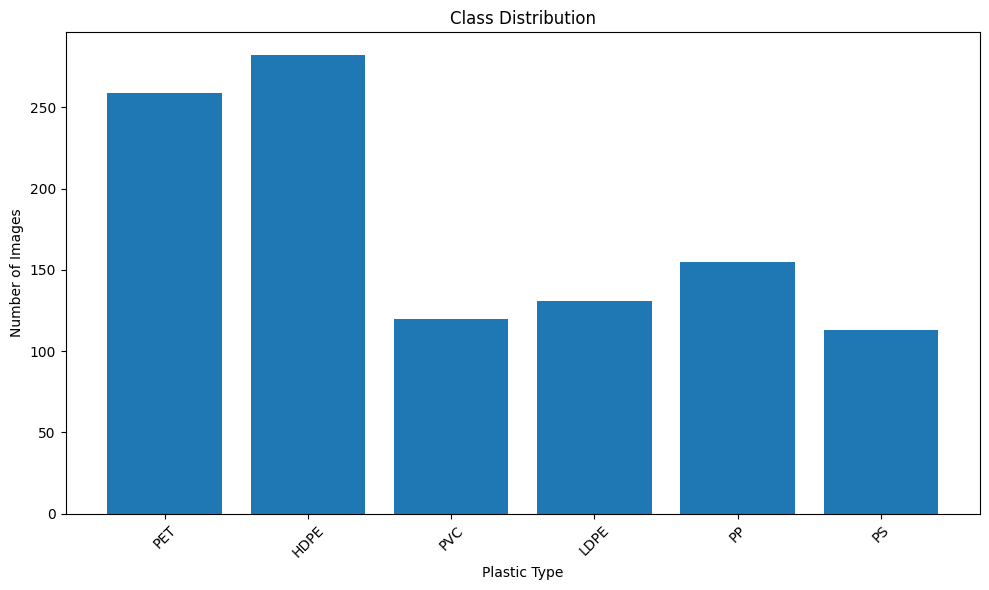

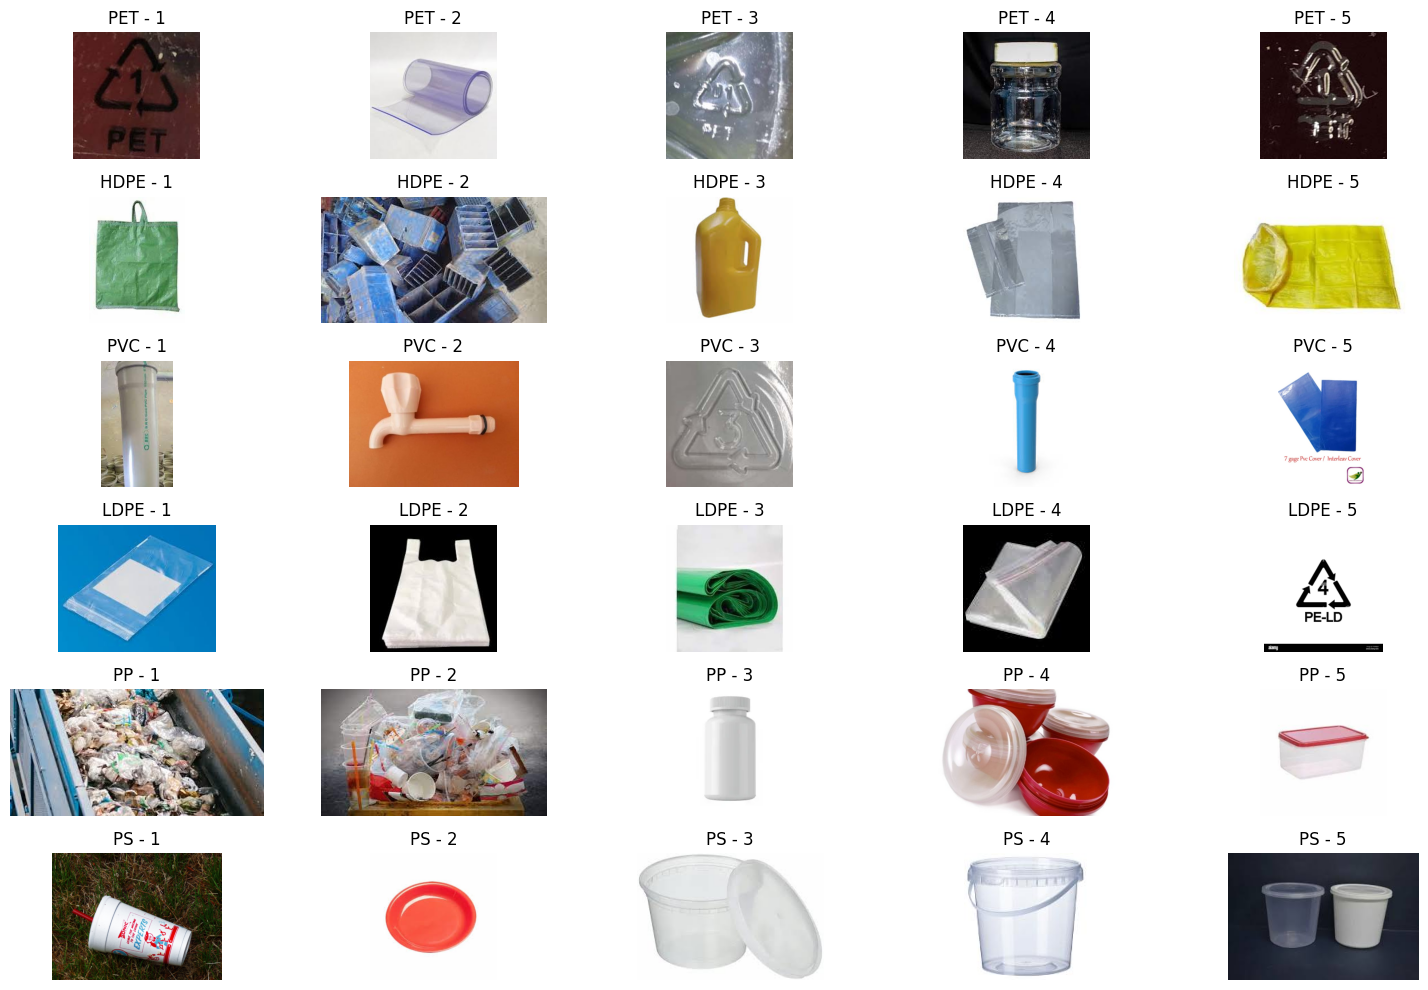

Sample of image dimensions:
Size (273, 185): 1 images
Size (267, 267): 1 images
Size (168, 300): 1 images
Size (405, 405): 1 images
Size (125, 125): 3 images
Size (350, 350): 1 images
Size (246, 204): 1 images
Size (1200, 1200): 1 images
Size (300, 300): 1 images
Size (217, 232): 2 images
Size (201, 251): 1 images
Size (200, 200): 12 images
Size (192, 263): 1 images
Size (168, 299): 1 images
Size (276, 183): 1 images
Size (188, 250): 1 images
Size (300, 168): 1 images
Size (600, 600): 1 images
Size (500, 464): 1 images
Size (259, 194): 1 images
Size (1000, 750): 1 images
Size (450, 338): 1 images
Size (266, 190): 1 images
Size (500, 421): 1 images
Size (252, 200): 1 images
Size (250, 188): 1 images
Size (267, 204): 1 images
Size (500, 375): 1 images
Size (500, 500): 7 images
Size (141, 250): 1 images
Size (500, 323): 1 images
Size (312, 162): 1 images
Size (181, 279): 1 images
Size (240, 210): 1 images
Size (730, 730): 1 images
Size (225, 225): 25 images
Size (163, 250): 1 images
Size 

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 78 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 21 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,046,726 (11.62 MB)

 Trainable params: 788,742 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.1601 - loss: 2.2938
Epoch 1: val_accuracy improved from -inf to 0.34031, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 876ms/step - accuracy: 0.1618 - loss: 2.2850 - val_accuracy: 0.3403 - val_loss: 1.6889
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.2568 - loss: 1.8466
Epoch 2: val_accuracy improved from 0.34031 to 0.41885, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 429ms/step - accuracy: 0.2588 - loss: 1.8419 - val_accuracy: 0.4188 - val_loss: 1.5221
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.3638 - loss: 1.5991
Epoch 3: val_accuracy improved from 0.41885 to 0.45026, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 429ms/step - accuracy: 0.3645 - loss: 1.5975 - val_accuracy: 0.4503 - val_loss: 1.4604
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4009 - loss: 1.5958
Epoch 4: val_accuracy improved from 0.45026 to 0.50262, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 425ms/step - accuracy: 0.4019 - loss: 1.5923 - val_accuracy: 0.5026 - val_loss: 1.3910
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.3893 - loss: 1.4991
Epoch 5: val_accuracy improved from 0.50262 to 0.51309, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - accuracy: 0.3902 - loss: 1.4984 - val_accuracy: 0.5131 - val_loss: 1.3512
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.4844 - loss: 1.3788
Epoch 6: val_accuracy improved from 0.51309 to 0.52880, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - accuracy: 0.4839 - loss: 1.3786 - val_accuracy: 0.5288 - val_loss: 1.3166
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5058 - loss: 1.3220
Epoch 7: val_accuracy improved from 0.52880 to 0.56545, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - accuracy: 0.5058 - loss: 1.3209 - val_accuracy: 0.5654 - val_loss: 1.2521
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.5230 - loss: 1.3031
Epoch 8: val_accuracy improved from 0.56545 to 0.57592, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - accuracy: 0.5232 - loss: 1.3014 - val_accuracy: 0.5759 - val_loss: 1.2259
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.5204 - loss: 1.2206
Epoch 9: val_accuracy did not improve from 0.57592
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5208 - loss: 1.2204 - val_accuracy: 0.5759 - val_loss: 1.2163
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5426 - loss: 1.2376
Epoch 10: val_accuracy did not improve from 0.57592
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.5427 - loss: 1.2370 - val_accuracy: 0.5707 - val_loss: 1.2039
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.5712 - loss: 1.2096
Epoch 11: val_accuracy improved from 0.57592 to 0.60733, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - accuracy: 0.5713 - loss: 1.2084 - val_accuracy: 0.6073 - val_loss: 1.1552
Epoch 12/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.5894 - loss: 1.0885
Epoch 12: val_accuracy did not improve from 0.60733
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 408ms/step - accuracy: 0.5898 - loss: 1.0874 - val_accuracy: 0.6021 - val_loss: 1.1437
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5864 - loss: 1.1082
Epoch 13: val_accuracy did not improve from 0.60733
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - accuracy: 0.5862 - loss: 1.1081 - val_accuracy: 0.5969 - val_loss: 1.1337
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6375 - loss: 1.0089
Epoch 14: val_accuracy improved from 0.60733 to 0.61257, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step - accuracy: 0.6368 - loss: 1.0100 - val_accuracy: 0.6126 - val_loss: 1.1098
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6570 - loss: 1.0067
Epoch 15: val_accuracy improved from 0.61257 to 0.61780, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.6562 - loss: 1.0075 - val_accuracy: 0.6178 - val_loss: 1.1117
Epoch 16/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6583 - loss: 0.9959
Epoch 16: val_accuracy improved from 0.61780 to 0.63351, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 423ms/step - accuracy: 0.6576 - loss: 0.9966 - val_accuracy: 0.6335 - val_loss: 1.0898
Epoch 17/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.6865 - loss: 0.9331
Epoch 17: val_accuracy improved from 0.63351 to 0.65969, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - accuracy: 0.6843 - loss: 0.9341 - val_accuracy: 0.6597 - val_loss: 1.0896
Epoch 18/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6257 - loss: 0.9975
Epoch 18: val_accuracy improved from 0.65969 to 0.68063, saving model to plastic_classifier_best.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 423ms/step - accuracy: 0.6258 - loss: 0.9976 - val_accuracy: 0.6806 - val_loss: 1.0694
Epoch 19/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6478 - loss: 0.9639
Epoch 19: val_accuracy did not improve from 0.68063
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - accuracy: 0.6479 - loss: 0.9629 - val_accuracy: 0.6492 - val_loss: 1.0749
Epoch 20/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6440 - loss: 0.9558
Epoch 20: val_accuracy did not improve from 0.68063
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step - accuracy: 0.6444 - loss: 0.9548 - val_accuracy: 0.6649 - val_loss: 1.0650
Epoch 21/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6840 - loss: 0.8638
Epoch 21: val_accuracy did not improve from 0.68063
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.6830 - loss: 0.8656 - val_accuracy: 0.6440 - val_loss: 1.0493
Epoch 22/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7040 - loss: 0.8562
Epoch 22: val_accuracy di

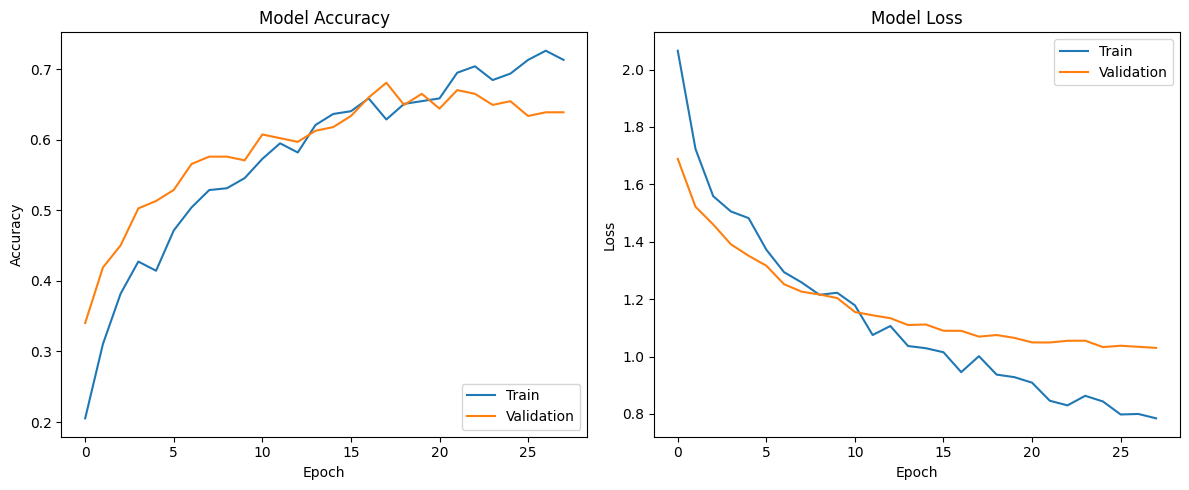

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6867 - loss: 1.0362
Validation Accuracy: 0.6806
Validation Loss: 1.0694
Current accuracy (68.06%) is below the 90% target. Consider fine-tuning or more augmentation.
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 694ms/step


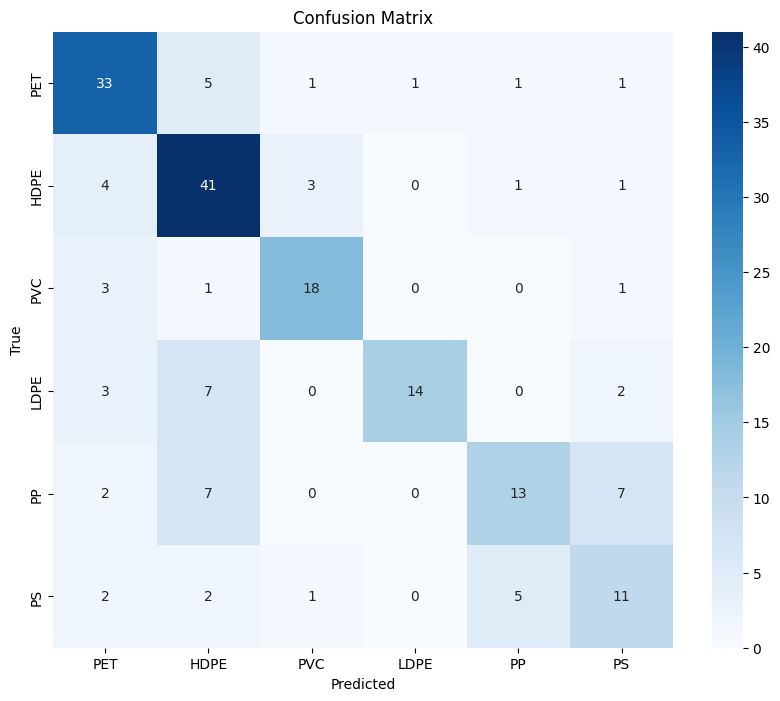

Model training and evaluation complete!
Starting fine-tuning to improve accuracy...
Could not identify the base model. Using a different approach.
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4235 - loss: 1.5118
Epoch 1: val_accuracy improved from -inf to 0.66492, saving model to plastic_classifier_finetuned.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4236 - loss: 1.5112 - val_accuracy: 0.6649 - val_loss: 1.0596
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.4150 - loss: 1.4670
Epoch 2: val_accuracy did not improve from 0.66492
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - accuracy: 0.4153 - loss: 1.4668 - val_accuracy: 0.6440 - val_loss: 1.0607
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.4724 - loss: 1.3940
Epoch 3: val_accuracy did not improve from 0.66492
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - accuracy: 0.4725 - loss: 1.3933 - val_accuracy: 0.6440 - val_loss: 1.0626
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.4654 - loss: 1.3647
Epoch 4: val_accuracy did not improve from 0.66492
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - accuracy: 0.4660 - loss: 1.3642 - val_accuracy: 0.6283 - val_loss: 1.0659
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.4607 - loss: 1.3755
Epoch 5: val_accuracy did not impr

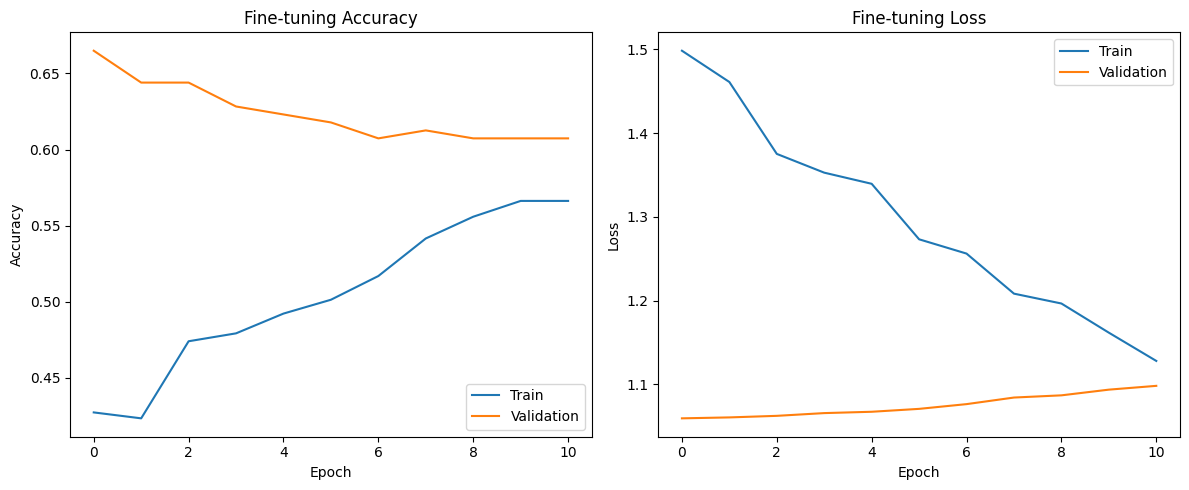

Saved artifact at '/tmp/tmpbwfu8s8f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139535825720656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535825720848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535825723920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535825723536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535825722384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535825724112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535825723152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535825719312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535825724304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139535825721808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13953582572468

In [ ]:
# Step 3: Transfer Learning Model

def create_model(num_classes=6):
    """
    Create a transfer learning model using MobileNetV2.

    Args:
        num_classes: Number of classes for classification

    Returns:
        Compiled model ready for training
    """
    # Load MobileNetV2 pre-trained on ImageNet without the top layer
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMAGE_SIZE, 3)
    )

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())
    return model

# Main execution

def fine_tune_model(model, train_generator, val_generator, unfreeze_layers=30):
    """
    Fine-tune the model by unfreezing some layers of the base model.

    Args:
        model: The pre-trained model
        train_generator: Training data generator
        val_generator: Validation data generator
        unfreeze_layers: Number of layers to unfreeze from the end of the base model

    Returns:
        History object containing training metrics
    """
    # Find the MobileNetV2 base model
    for layer in model.layers:
        if isinstance(layer, tf.keras.models.Model):  # This will be our base_model
            base_model = layer
            break
    else:
        # If no nested model is found, use a different approach
        # Look for the layer named 'mobilenetv2'
        base_model = None
        for layer in model.layers:
            if 'mobilenetv2' in layer.name.lower():
                base_model = layer
                break

    # If we found the base model, unfreeze some layers
    if base_model is not None:
        print(f"Found base model: {base_model.name}")

        # Get the total number of layers
        total_layers = len(base_model.layers)
        print(f"Total layers in base model: {total_layers}")

        # Make sure we don't try to unfreeze more layers than exist
        layers_to_unfreeze = min(unfreeze_layers, total_layers)

        # Unfreeze the specified number of layers from the end
        for layer in base_model.layers[-layers_to_unfreeze:]:
            layer.trainable = True
            print(f"Unfreezing layer: {layer.name}")
    else:
        print("Could not identify the base model. Using a different approach.")
        # Alternative approach: unfreeze all layers except the first few
        for layer in model.layers[3:]:  # Skip first few layers
            layer.trainable = True

    # Recompile with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE / 10),  # Lower learning rate for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks for fine-tuning
    checkpoint = ModelCheckpoint(
        'plastic_classifier_finetuned.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # Fine-tune the model
    history = model.fit(
        train_generator,
        epochs=30,  # Fewer epochs for fine-tuning
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping]
    )

    return history

def optimize_for_edge(model, save_path):
    """
    Optimize the model for edge deployment by converting to TFLite format.

    Args:
        model: Trained model to optimize
        save_path: Path to save the optimized model
    """
    # Convert to TFLite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Apply optimizations
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Quantize the model to reduce size (optional)
    # converter.target_spec.supported_types = [tf.float16]

    # Convert the model
    tflite_model = converter.convert()

    # Save the model
    with open(save_path, 'wb') as f:
        f.write(tflite_model)

    print(f"Model optimized and saved to {save_path}")

    # Calculate model size
    model_size = os.path.getsize(save_path) / (1024 * 1024)  # Size in MB
    print(f"TFLite model size: {model_size:.2f} MB")

    return save_path

def generate_predictions(model, test_image_paths):
    """
    Generate predictions for test images.

    Args:
        model: Trained model
        test_image_paths: List of paths to test images

    Returns:
        DataFrame with test image paths and predicted classes
    """
    predictions = []

    for img_path in test_image_paths:
        # Load and preprocess the image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Make prediction
        pred = model.predict(img_array)
        pred_class_idx = np.argmax(pred[0])
        pred_class = CLASSES[pred_class_idx]
        confidence = pred[0][pred_class_idx]

        predictions.append({
            'image_path': img_path,
            'predicted_class': pred_class,
            'confidence': confidence
        })

    # Create DataFrame
    results_df = pd.DataFrame(predictions)
    return results_df

if __name__ == "__main__":
    # Set the path to your dataset
    dataset_path = "/content/Dataset"  # Update this with your actual path

    # Clean and explore the dataset
    image_paths, labels = clean_dataset(dataset_path)
    explore_dataset(image_paths, labels)

    # Create datasets
    train_generator, val_generator = create_datasets(image_paths, labels, VALIDATION_SPLIT)

    # Create and compile the model
    model = create_model(len(CLASSES))

    # Define callbacks
    checkpoint = ModelCheckpoint(
        'plastic_classifier_best.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[checkpoint, early_stopping]
    )

    # Plot training history
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(val_generator)
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    # Check if we meet the >90% accuracy requirement
    if val_accuracy >= 0.9:
        print("SUCCESS: Model achieved >90% validation accuracy!")
    else:
        print(f"Current accuracy ({val_accuracy:.2%}) is below the 90% target. Consider fine-tuning or more augmentation.")

    # Generate confusion matrix
    # Reset the generator to ensure we get predictions in the right order
    val_generator.reset()

    # Get predictions
    predictions = model.predict(val_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels (need to get the right number from the generator)
    true_classes = val_generator.classes[:len(predicted_classes)]

    # Plot confusion matrix
    cm = tf.math.confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("Model training and evaluation complete!")

    # If accuracy is below 90%, try fine-tuning
    if val_accuracy < 0.9:
        print("Starting fine-tuning to improve accuracy...")
        fine_tune_history = fine_tune_model(model, train_generator, val_generator)

        # Re-evaluate after fine-tuning
        val_loss, val_accuracy = model.evaluate(val_generator)
        print(f"After fine-tuning - Validation Accuracy: {val_accuracy:.4f}")

        # Plot fine-tuning history
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(fine_tune_history.history['accuracy'])
        plt.plot(fine_tune_history.history['val_accuracy'])
        plt.title('Fine-tuning Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='lower right')

        plt.subplot(1, 2, 2)
        plt.plot(fine_tune_history.history['loss'])
        plt.plot(fine_tune_history.history['val_loss'])
        plt.title('Fine-tuning Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper right')

        plt.tight_layout()
        plt.show()

    # Save the full model (in case we want to use it directly)
    model.save('plastic_classifier_full_model.h5')

    # Optional: Optimize for edge deployment
    tflite_path = optimize_for_edge(model, 'plastic_classifier.tflite')

    # Generate predictions for test images
    # Update this path with the location of your test images
    test_image_dir = "/content/plastic_images/plastic_images"
    test_image_paths = [os.path.join(test_image_dir, f) for f in os.listdir(test_image_dir)
                       if os.path.isfile(os.path.join(test_image_dir, f))]

    if test_image_paths:
        print(f"Generating predictions for {len(test_image_paths)} test images...")
        results_df = generate_predictions(model, test_image_paths)

        # Save results to CSV
        results_df.to_csv('submission_predictions.csv', index=False)
        print("Predictions saved to 'submission_predictions.csv'")

        # Display prediction results
        print(results_df)